## Food data Analysis and Model

In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")
from konlpy.tag import Twitter
import lightgbm as lgb
from sklearn.preprocessing import Imputer
from sklearn import preprocessing
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')

In [25]:
def Food_data_setting():
    food = pd.read_csv("한국관광공사_전국_음식점_정보_20160906.csv",sep=None ,encoding="cp949")
    food = food.filter(items=['카테고리3', '개요'])
    food = food.dropna()
    
    return food

food = Food_data_setting()

In [26]:
food.tail()

,카테고리3,개요
6104,한식,경기도 일산에서 가장 오랜되고 맛있는 집으로 소문난 집이다. 13년동안 한곳에서 한...
6105,한식,팔팔민물장어는 30년 전통으로 오직 장어만을 전문으로 하는 장어전문 요리집이다. 3...
6106,서양식,서울스퀘어에 자리잡은 크라제버거. 1998년 11월 압구정동에 국내에서는 처음으로...
6107,서양식,이태리식 레스토랑으로써 음식에 사용되는 모든 신선한 재료들을 그릴(숯을 이용)에 한...
6108,한식,경상북도 청송군 청송읍 부곡리에 위치한 봉산식당은 달기약수를 이용한 백숙을 전문으로...


---

### 분석

In [6]:
from konlpy.tag import Twitter
from konlpy.tag import *
hannanum = Hannanum()
kkma = Kkma()
twitter = Twitter()

def tokenize_pos(doc):
    return ['/'.join(t) for t in twitter.pos(doc)]

In [7]:
clf = Pipeline([
    ("vect", TfidfVectorizer(tokenizer=tokenize_pos, ngram_range=(1,2))), 
    ("clf", MultinomialNB(alpha=0.01))
])

In [27]:
# Labeling
# le = preprocessing.LabelEncoder()
# y_label = le.fit_transform(food['카테고리3'])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(food['개요'], food['카테고리3'], \
                                                    test_size=0.4, random_state=0)

len(X_train),len(X_test),len(y_train),len(y_test)

(3644, 2430, 3644, 2430)

Train 

Train confusion_matrix 

[[ 191    1    0    0    0    0    0    0    0]
 [   0   65    0    0    0    0    0    0    0]
 [   0    0   14    0    0    0    0    0    0]
 [   0    0    0  105    0    0    0    0    0]
 [   0    0    0    0  149    0    0    0    0]
 [   0    0    0    0    0   16    0    0    0]
 [   0    0    0    0    0    0  163    0    0]
 [   0    0    0    0    0    0    0   23    0]
 [   0    0    0    3    0    0    0    0 2914]] 


Train classification_report 

             precision    recall  f1-score   support

        서양식       1.00      0.99      1.00       192
       아시아식       0.98      1.00      0.99        65
      이색음식점       1.00      1.00      1.00        14
         일식       0.97      1.00      0.99       105
         중식       1.00      1.00      1.00       149
      채식전문점       1.00      1.00      1.00        16
    카페/전통찻집       1.00      1.00      1.00       163
    패밀리레스토랑       1.00      1.00      1.00        23
         한식       1.00 

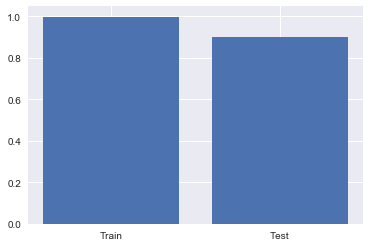

In [11]:
# def Food():

model  = clf.fit(X_train, y_train)

y_pred  = model.predict(X_train)

print("Train", "\n")
print("Train confusion_matrix", "\n")
print(confusion_matrix(y_train, y_pred), "\n\n")
print("Train classification_report", "\n")
print(classification_report(y_train, y_pred), "\n\n")
print("Train accuracy_score", "\n")
print(round(accuracy_score(y_train, y_pred), 2), "\n\n")

print("=====================================================" , "\n\n")

y_pred_t = model.predict(X_test)

print("Test", "\n")
print("Test confusion_matrix", "\n")
print(confusion_matrix(y_test, y_pred_t), "\n\n")
print("Test classification_report", "\n")
print(classification_report(y_test, y_pred_t), "\n\n")
print("Test accuracy_score", "\n")
print(round(accuracy_score(y_test, y_pred_t), 2), "\n\n")

x="Train","Test"
y=accuracy_score(y_train, y_pred), accuracy_score(y_test, y_pred_t)
plt.bar(x,y)
plt.show()

### 문구 Test

In [20]:
X_=pd.Series("피자")

In [21]:
y_pred_t = model.predict_proba(X_)
y_pred = model.predict(X_)

In [22]:
y_pred_t

array([[8.28887169e-01, 1.89651581e-02, 3.15902769e-04, 1.45326892e-03,
        1.79545080e-03, 3.49206028e-04, 4.67012381e-02, 7.20823340e-03,
        9.43243727e-02]])

In [23]:
y_pred

array(['서양식'], dtype='<U7')

---